# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
pip install matplotlib-venn


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp


# Read and clean data

In [4]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


Import your data, either through an API or manually, and load it. 

In [5]:
effective_int = (pd.read_csv('MPK100.csv'))
display(effective_int)

,LAND,TID,INDHOLD
0,Danmark,2013,1.7
1,Danmark,2014,1.3
2,Danmark,2015,0.7
3,Danmark,2016,0.3
4,Danmark,2017,0.5
...,...,...,...
94,Frankrig,2019,0.6
95,Frankrig,2020,0.7
96,Frankrig,2021,0.0
97,Frankrig,2022,3.6


In [6]:
#Changing names

effective_int.rename(columns = {'LAND':'COUNTRY', 'TID':'YEAR','INDHOLD':'INTEREST RATE'}, inplace=True)

country_mapping = {
    'Danmark': 'Denmark',
    'Schweiz': 'Switzerland',
    'Tyskland': 'Germany',
    'Japan': 'Japan',
    'Sverige': 'Sweden',
    'Norge': 'Norway',
    'Frankrig': 'France'
}

effective_int['COUNTRY'] = effective_int['COUNTRY'].replace(country_mapping)
effective_int.head(99)

,COUNTRY,YEAR,INTEREST RATE
0,Denmark,2013,1.7
1,Denmark,2014,1.3
2,Denmark,2015,0.7
3,Denmark,2016,0.3
4,Denmark,2017,0.5
...,...,...,...
94,France,2019,0.6
95,France,2020,0.7
96,France,2021,0.0
97,France,2022,3.6


In [7]:
#rentespænd langfristet

# Convert 'INTEREST RATE' column to numeric
effective_int['INTEREST RATE'] = pd.to_numeric(effective_int['INTEREST RATE'], errors='coerce')

# Filter the DataFrame to extract interest rates for Denmark and Germany
denmark_rates = effective_int[effective_int['COUNTRY'] == 'Denmark'].set_index('YEAR')['INTEREST RATE']
germany_rates = effective_int[effective_int['COUNTRY'] == 'Germany'].set_index('YEAR')['INTEREST RATE']
switzerland_rates = effective_int[effective_int['COUNTRY'] == 'Switzerland'].set_index('YEAR')['INTEREST RATE']
japan_rates = effective_int[effective_int['COUNTRY'] == 'Japan'].set_index('YEAR')['INTEREST RATE']
sweden_rates = effective_int[effective_int['COUNTRY'] == 'Sweden'].set_index('YEAR')['INTEREST RATE']
norway_rates = effective_int[effective_int['COUNTRY'] == 'Norway'].set_index('YEAR')['INTEREST RATE']
france_rates = effective_int[effective_int['COUNTRY'] == 'France'].set_index('YEAR')['INTEREST RATE']



# Calculate the difference between the interest rates of Denmark and Germany for each year
germany_difference = denmark_rates - germany_rates
switzerland_difference = denmark_rates - switzerland_rates
japan_difference = denmark_rates - japan_rates
sweden_difference = denmark_rates - sweden_rates
norway_difference = denmark_rates - norway_rates
france_difference = denmark_rates - france_rates

# Merging all the differences to one dataframe
all_countries = pd.DataFrame(columns=['COUNTRY', 'INTEREST DIFF'])

#1. Værdierne skal blive plottet henover årene  2013-2023
#2. Få alle kurverne ind i samme graf, som ses i ps4 Split-apply-combine plot

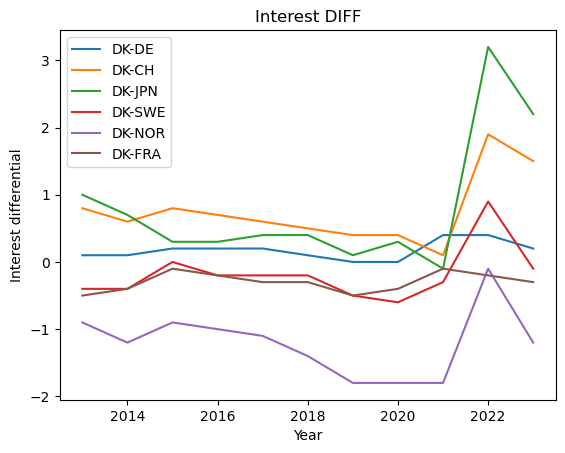

In [8]:
import matplotlib.pyplot as plt

# Example data
year1= [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Plot the curves for both variables
plt.plot(year1, germany_difference, label='DK-DE')
plt.plot(year1, switzerland_difference, label='DK-CH')
plt.plot(year1, japan_difference, label='DK-JPN')
plt.plot(year1, sweden_difference, label='DK-SWE')
plt.plot(year1, norway_difference, label='DK-NOR')
plt.plot(year1, france_difference, label='DK-FRA')
# Add labels and title
plt.xlabel('Year')
plt.ylabel('Interest differential')
plt.title('Interest DIFF')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [9]:
# The DST API wrapper
%pip install git+https://github.com/alemartinello/dstapi

  Cloning https://github.com/alemartinello/dstapi to c:\users\ejer\appdata\local\temp\pip-req-build-qb1qzd61
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi 'C:\Users\Ejer\AppData\Local\Temp\pip-req-build-qb1qzd61'


In [10]:
# A wrapper for multiple APIs with a pandas interface
%pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

In [20]:
ind = DstApi('PRIS111') 

In [21]:
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2024-03-11T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VAREGR,385,000000,"00 Consumer price index, total",151000,15.1 Overall Consumer Price Index excl. energy,False
1,ENHED,3,100,Index,300,Percentage change compared to same month the y...,False
2,Tid,278,2001M01,2001M01,2024M02,2024M02,True


In [22]:
# The available values for a each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(ind.variable_levels(variable, language='en'))

VAREGR:


,id,text
0,000000,"00 Consumer price index, total"
1,010000,01 Food and non-alcoholic beverages
2,011000,01.1 Food
3,011100,01.1.1 Bread and cereals
4,011110,01.1.1.1 Rice
...,...,...
380,127030,12.7.0.3 Funeral services
381,131000,13.1 Goods (total)
382,132000,13.2 Services (total)
383,141000,14.1 Overall Consumer Price Index - excl. ener...


ENHED:


,id,text
0,100,Index
1,200,Percentage change compared to previous month (...
2,300,Percentage change compared to same month the y...


Tid:


,id,text
0,2001M01,2001M01
1,2001M02,2001M02
2,2001M03,2001M03
3,2001M04,2001M04
4,2001M05,2001M05
...,...,...
273,2023M10,2023M10
274,2023M11,2023M11
275,2023M12,2023M12
276,2024M01,2024M01


In [23]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')

params

{'table': 'pris111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'VAREGR', 'values': ['*']},
  {'code': 'ENHED', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

We identify variables to be used

In [26]:
variables = params['variables'] # Returns a view, that we can edit
variables[0]['values'] = ['000000']
variables[1]['values'] =['300']
variables[2]['values'] = ['2013M12', '2014M12', '2015M12', '2016M12', '2017M12', '2018M12', '2019M12', '2020M12', '2021M12', '2022M12', '2023M12']
params

{'table': 'pris111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'VAREGR', 'values': ['000000']},
  {'code': 'ENHED', 'values': ['300']},
  {'code': 'Tid',
   'values': ['2013M12',
    '2014M12',
    '2015M12',
    '2016M12',
    '2017M12',
    '2018M12',
    '2019M12',
    '2020M12',
    '2021M12',
    '2022M12',
    '2023M12']}]}

Now we load the data from dst via the api using the options specified in the param dictionary 

In [28]:
inc_api = ind.get_data(params=params)
inc_api.head(11)

,VAREGR,ENHED,TID,INDHOLD
0,"00 Consumer price index, total",Percentage change compared to same month the y...,2013M12,0.7
1,"00 Consumer price index, total",Percentage change compared to same month the y...,2014M12,0.4
2,"00 Consumer price index, total",Percentage change compared to same month the y...,2015M12,0.4
3,"00 Consumer price index, total",Percentage change compared to same month the y...,2016M12,0.5
4,"00 Consumer price index, total",Percentage change compared to same month the y...,2017M12,1.0
5,"00 Consumer price index, total",Percentage change compared to same month the y...,2018M12,0.8
6,"00 Consumer price index, total",Percentage change compared to same month the y...,2019M12,0.8
7,"00 Consumer price index, total",Percentage change compared to same month the y...,2020M12,0.5
8,"00 Consumer price index, total",Percentage change compared to same month the y...,2021M12,3.1
9,"00 Consumer price index, total",Percentage change compared to same month the y...,2022M12,8.7


Data is now ready for cleaning and renaming

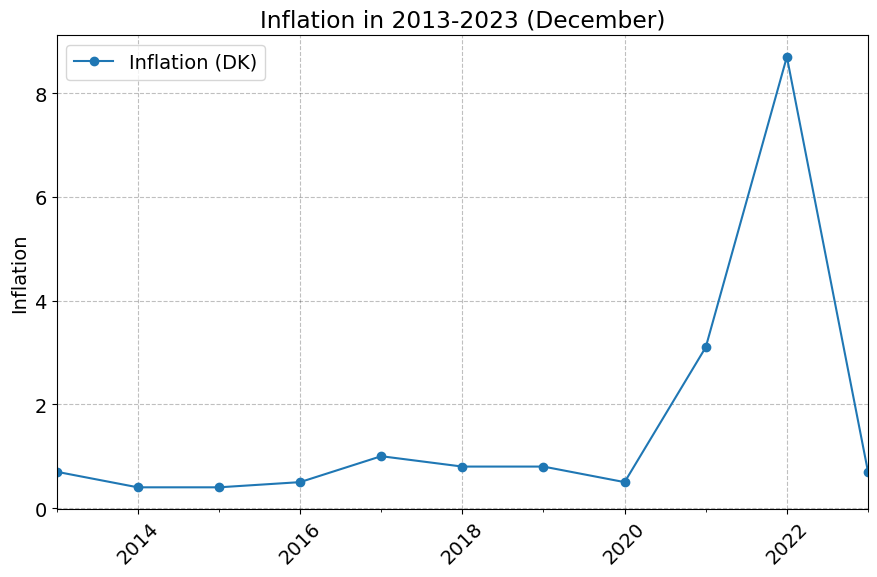

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Defining the data
dates = ['2013M12', '2014M12', '2015M12', '2016M12', '2017M12', '2018M12', '2019M12', '2020M12', '2021M12', '2022M12', '2023M12']
inflation_values = [0.7, 0.4, 0.4, 0.5, 1.0, 0.8, 0.8, 0.5, 3.1, 8.7, 0.7]

# Creating a pandas DataFrame
infla_dk = pd.DataFrame({'Inflation (DK)': inflation_values}, index=pd.to_datetime(dates, format='%YM%m'))

# Plotting
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1,1,1)
infla_dk.plot(ax=ax, legend=True, marker='o')

ax.legend(frameon=True)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Inflation in 2013-2023 (December)')
ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

We observe the inflation in the given period.... 
.
.
.
What now is interesting to look at?

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [16]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

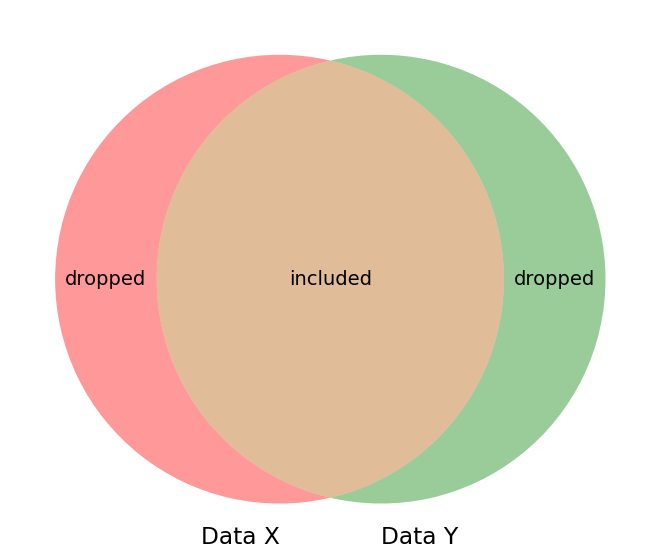

In [17]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.